#  Practical assessment for Business Intelligence Analyst

##  Problem Setting
- You are supporting an e-commerce platform
- Currently, the decision making at this company is not
very data-informed
- They do not own a data warehouse and do not have automated reports
- You are able to access backend data about customers and orders

## Task
In 2 weeks time the CEO of the company has to present to investment board members how the company is currently doing. While preparing his presentation, he assumes the following:
- The company is growing in terms of customers and conversions and growth is healthy.
- The company should invest more in Offline sales, which look promising.
- There are certain customer segments that behave significantly different than others.
He wants you to analyze and make sense of the given data to help him support/disagree with his assumptions.

##  Resources

### customers.csv

| column | content |
|---|---|
| customer_id | an identifier for the customer |
| first_order_day | the date, when the customer ordered the first time |
| customer_type | B2B or B2C |
| primary_sales_channel | offline or online |

### orders.csv

| column | content |
|---|---|
| order_id | an identifier for the order |
| customer_id | an identifier for the customer |
| order_date | date when the order was placed |
| revenue | revenue in EUR that is generated by this order |



### monthly_revenue_2016.csv
This csv contains historical data for the monthly revenue in 2016 that was aggregated by a former data analyst


## 1. data import, cleaning and wrangling

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
path = "data/"

customers = pd.read_csv(path+"customers.csv")
orders = pd.read_csv(path+"orders.csv")
monthly_revenue = pd.read_csv(path+"monthly_revenue_2016.csv")

### customers

In [3]:
customers.head()

,customer_id,customer_type,primary_sales_channel,first_order_day_fk
0,K0100097,B2C,Offline,20170117
1,K0100437,B2C,Offline,20170118
2,K0100451,B2C,Offline,20170118
3,K0100585,B2C,Offline,20170119
4,K0100681,B2C,Offline,20170120


In [4]:
print(customers.shape)
print(customers.dtypes)

(11628, 4)
customer_id              object
customer_type            object
primary_sales_channel    object
first_order_day_fk        int64
dtype: object


In [5]:
customers["customer_type"].value_counts()/len(customers)

B2C    0.995872
B2B    0.004128
Name: customer_type, dtype: float64

In [6]:
customers["primary_sales_channel"].value_counts()/len(customers)

Online     0.868163
Offline    0.131837
Name: primary_sales_channel, dtype: float64

In [7]:
customers["customer_id"].nunique()

11628

In [8]:
customers.isna().sum()

customer_id              0
customer_type            0
primary_sales_channel    0
first_order_day_fk       0
dtype: int64

- unique customers id (same unique values as dataset length)
- 2 types of customers, 99,5% B2C
- 2 types of channels, almost 87% online
- no NaN
- we need to work with the date format

In [9]:
# transform format into date
customers["date_first_order"] = pd.to_datetime(customers["first_order_day_fk"], format="%Y%m%d")

In [10]:
# drop column
customers = customers.drop(columns=["first_order_day_fk"])

In [11]:
customers.describe().T

,count,unique,top,freq,first,last
customer_id,11628,11628,K292032709,1,NaT,NaT
customer_type,11628,2,B2C,11580,NaT,NaT
primary_sales_channel,11628,2,Online,10095,NaT,NaT
date_first_order,11628,786,2017-01-08 00:00:00,118,2014-09-03,2017-06-30


### orders

In [12]:
orders

,order_id,customer_id,order_date_fk,revenue
0,96149,K4078373803.0,20170101,128.70
1,281101,K3929324291.0,20170101,125.33
2,96244,K1706191515.0,20170101,118.09
3,96162,K4291564253.0,20170101,80.80
4,96204,K3541486465.0,20170101,75.80
...,...,...,...,...
24061,291614,K424139434.0,20170630,12.97
24062,303595,K2958888446.0,20170630,11.98
24063,293138,K708187630.0,20170630,11.98
24064,298788,K3477419091.0,20170630,11.89


In [13]:
orders.dtypes

order_id           int64
customer_id       object
order_date_fk      int64
revenue          float64
dtype: object

- order_id doesn't refer to a number, therefore should be object
- change order_date_fk format


In [14]:
orders["order_id"] = orders["order_id"].astype("object")

In [15]:
orders["order_date"] = pd.to_datetime(orders["order_date_fk"], format="%Y%m%d")
# drop column
orders = orders.drop(columns=["order_date_fk"])

In [16]:
orders.dtypes

order_id               object
customer_id            object
revenue               float64
order_date     datetime64[ns]
dtype: object

In [17]:
orders

,order_id,customer_id,revenue,order_date
0,96149,K4078373803.0,128.70,2017-01-01
1,281101,K3929324291.0,125.33,2017-01-01
2,96244,K1706191515.0,118.09,2017-01-01
3,96162,K4291564253.0,80.80,2017-01-01
4,96204,K3541486465.0,75.80,2017-01-01
...,...,...,...,...
24061,291614,K424139434.0,12.97,2017-06-30
24062,303595,K2958888446.0,11.98,2017-06-30
24063,293138,K708187630.0,11.98,2017-06-30
24064,298788,K3477419091.0,11.89,2017-06-30


### monthly revenue

In [18]:
# add year to monthly revenue
monthly_revenue["year"] = "2016" + " " + monthly_revenue["month"]
# convert into date (attributed to first day of the month)
monthly_revenue["date"] = pd.to_datetime(monthly_revenue["year"])
# drop columns "month" & "year"
monthly_revenue = monthly_revenue.drop(columns=["month","year"])

In [19]:
# add year-month to orders

orders["month"] = pd.DatetimeIndex(orders["order_date"]).month
orders["year"] = pd.DatetimeIndex(orders["order_date"]).year
orders["year_month"] = pd.to_datetime(orders["year"].astype(str)+"-"+orders["month"].astype(str))

In [20]:
# group by month
monthly_revenue_2017 = orders.groupby(["year_month"]).sum()["revenue"]
monthly_revenue_2017 = monthly_revenue_2017.to_frame().reset_index()

In [21]:
# re-arrange monthly_revenue_2017
monthly_revenue_2017 = monthly_revenue_2017[["year_month","revenue"]]

In [22]:
# re-arrange monthly_revenue
monthly_revenue["revenue"] = monthly_revenue["revenue(EUR)"]
monthly_revenue["year_month"] = monthly_revenue["date"]
monthly_revenue_2016 = monthly_revenue[["year_month","revenue"]]


In [23]:
# concat revenue 2016 & 2017
monthly_revenue = pd.concat([monthly_revenue_2016, monthly_revenue_2017]).reset_index(drop=True)

In [24]:
monthly_revenue

,year_month,revenue
0,2016-01-01,223803.40
1,2016-02-01,152010.60
2,2016-03-01,207492.59
3,2016-04-01,198400.37
4,2016-05-01,172665.00
5,2016-06-01,92489.00
6,2016-07-01,88955.01
7,2016-08-01,154239.94
8,2016-09-01,175366.28
9,2016-10-01,194802.03


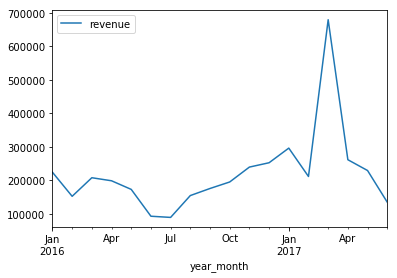

In [25]:
monthly_revenue.set_index("year_month").plot();

### monthly orders

In [26]:
monthly_orders = orders.groupby(by=["year_month"]).agg(["count", "sum","mean"])["revenue"]
monthly_orders

,count,sum,mean
year_month,,,
2017-01-01,6462,295974.75,45.802344
2017-02-01,3699,211228.35,57.104177
2017-03-01,3604,679477.52,188.534273
2017-04-01,3851,261289.01,67.849652
2017-05-01,4119,229030.20,55.603350
2017-06-01,2331,134431.25,57.671064


In [27]:
pd.DatetimeIndex(orders["order_date"]).year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='order_date', length=24066)

# Questions
## The company is growing in terms of customers and conversions and growth is healthy
#### Is the company healthy growing?

In [28]:
monthly_revenue

,year_month,revenue
0,2016-01-01,223803.40
1,2016-02-01,152010.60
2,2016-03-01,207492.59
3,2016-04-01,198400.37
4,2016-05-01,172665.00
5,2016-06-01,92489.00
6,2016-07-01,88955.01
7,2016-08-01,154239.94
8,2016-09-01,175366.28
9,2016-10-01,194802.03


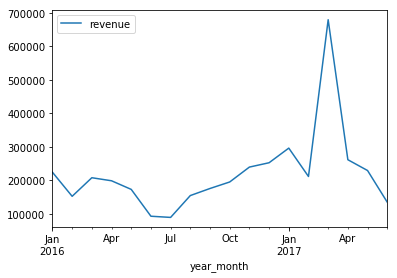

In [29]:
monthly_revenue.set_index("year_month").plot();

In [30]:
# prepare data for fitted line

# create time variable
monthly_revenue_lr = monthly_revenue.assign(t=monthly_revenue.index+1)

# create constant
monthly_revenue_lr = monthly_revenue_lr.assign(constant=1)

monthly_revenue_lr = monthly_revenue_lr.set_index("year_month")



In [31]:
# run linear regression
rev_train = monthly_revenue_lr.loc["2016-01-01":"2017-06-01"]

# create variables
y = rev_train["revenue"]
X = rev_train[["constant", "t"]]
lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [32]:
results.summary()

/Users/ivanlopezlobato/miniconda3/envs/code_red/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.498
Date:                Wed, 24 Jun 2020   Prob (F-statistic):              0.134
Time:                        18:42:09   Log-Likelihood:                -235.29
No. Observations:                  18   AIC:                             474.6
Df Residuals:                      16   BIC:                             476.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.369e+05      6e+04      2.282      0.036    9751.434    2.64e+05
t           8761.3767   5543.040      1.581      0.134   -2989.343    2.05e+04
==============================================================================
Omnibus:                       27.382   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.428
Skew:                           2.310   Prob(JB):                     8.28e-11
Kurtosis:                       9.369   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
results.params

constant    136945.397778
t             8761.376667
dtype: float64

In [34]:
# make a copy
monthly_revenue_pred = monthly_revenue_lr.copy()

# assign values of linear regression to plot
monthly_revenue_pred = monthly_revenue_pred.assign(predicted_revenue=(results.params["constant"] + monthly_revenue_pred["t"] * results.params["t"]))

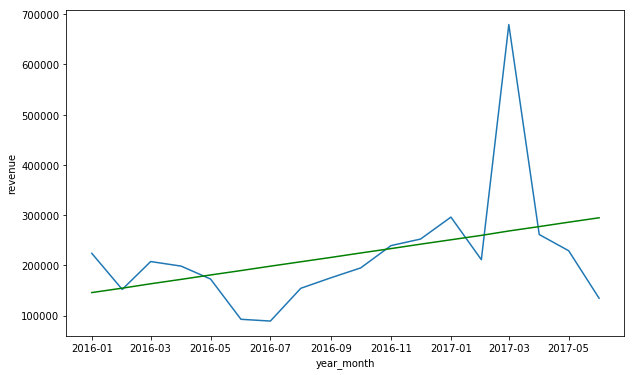

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=monthly_revenue_pred.loc["2016-01-01":"2017-06-01"],
             x=monthly_revenue_pred.loc["2016-01-01":"2017-06-01"].index,
             y="revenue",
             ax=ax);
ax.plot(monthly_revenue_pred.loc["2016-01-01":"2017-06-01", "predicted_revenue"], color="green");

We observe that the trend (linear regression) of the values along 18 months is ascending in regards of the revenue, so we can state that we are growing
However, we can detect an unexpected peak in March 2017, that might be the main cause the growth.

to check in detail, we visualize growth YoY

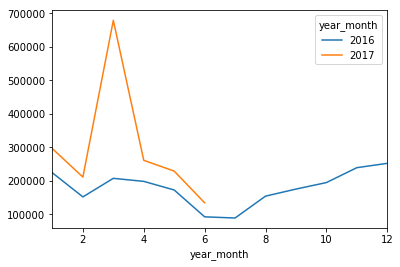

In [36]:
# compare Year over Year
pd.pivot_table(monthly_revenue,
               index=pd.DatetimeIndex(monthly_revenue["year_month"]).month,
               columns=pd.DatetimeIndex(monthly_revenue["year_month"]).year,
               values="revenue").plot();